In [108]:
import pandas as pd
import numpy as np
import random
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from ultralytics import YOLO
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import os
import shutil

import cv2

import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px

from ipywidgets import widgets, VBox, HBox

from IPython.display import display, clear_output

from PIL import Image, ImageDraw, ImageFont

import base64
from io import BytesIO

from tqdm import tqdm

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, make_scorer
from sklearn.linear_model import PoissonRegressor, LinearRegression, Ridge
from sklearn.svm import SVR

from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

# Importing Data

In [168]:
#train_df = pd.read_csv('Combined Data/train_df.csv').drop_duplicates()
#test_df = pd.read_csv('Combined Data/test_df.csv')

train_df = pd.read_csv('Combined Data/train_df_more.csv').drop_duplicates()
test_df = pd.read_csv('Combined Data/test_df_more.csv')

# A bit of EDA

In [169]:
train_df.head(3)

,pothole_id,mm_to_pixel_ratio,pothole_length_mm,pothole_width_mm,pothole_area_mm2,pothole_aspect_ratio,pothole_perimeter_mm,pothole_compactness,bags_used
0,p1036,2.024225,485.814034,368.408976,1.143629e+05,1.318681,1708.446019,0.039182,0.5
1,p1022,2.233278,1817.888392,1181.404127,1.685416e+06,1.538752,5998.585037,0.046839,2.0
2,p417,2.744603,850.826793,606.557165,3.453620e+05,1.402715,2914.767916,0.040651,0.5


In [170]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_df.drop(['pothole_id', 'bags_used'],axis=1))
pca_df = pd.DataFrame(X_pca, columns=['pc1', 'pc2'], index=train_df.index)
pca_df['bags_used'] = train_df['bags_used']

<Axes: xlabel='pc1', ylabel='pc2'>

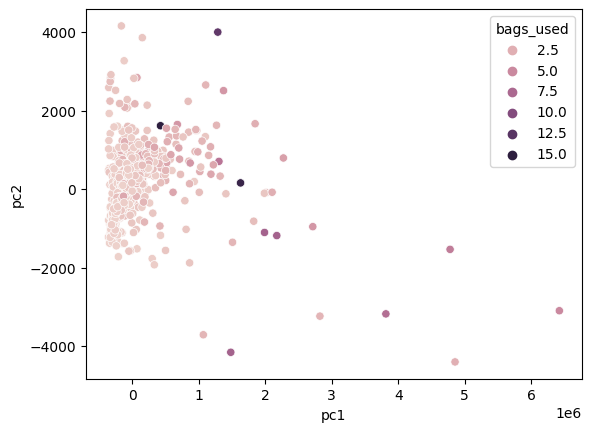

In [171]:
sns.scatterplot(pca_df, x='pc1', y='pc2', hue='bags_used')

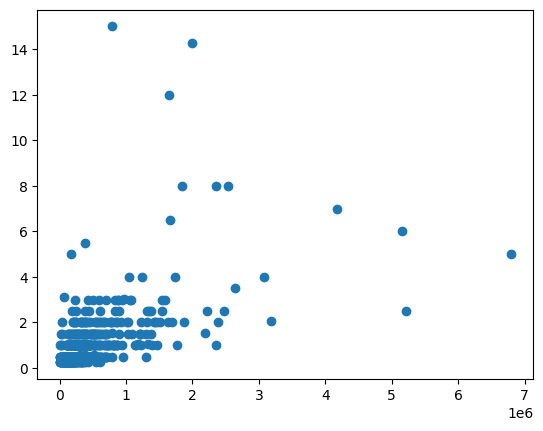

In [172]:
plt.scatter(train_df['pothole_area_mm2'], train_df['bags_used'])

In [173]:
train_df['bags_used'].value_counts().sort_index()

bags_used
0.25     168
0.50     363
0.55       3
1.00     180
1.05       3
1.50      61
1.55       2
2.00      47
2.05       1
2.50      14
3.00      13
3.05       1
3.10       1
3.50       1
4.00       4
5.00       2
5.50       1
6.00       1
6.50       1
7.00       1
8.00       3
12.00      1
14.25      1
15.00      1
Name: count, dtype: int64

### Binning Values

In [175]:
def round_bags_used(value):
    if 0.45 <= value <= 0.55:
        return 0.5
    elif 1.00 <= value <= 1.10:
        return 1.0
    elif 1.45 <= value <= 1.55:
        return 1.5
    elif 2.00 <= value <= 2.10:
        return 2.0
    elif 3.00 <= value <= 3.10:
        return 3.0
    elif 5.00 <= value <= 5.50:
        return 5.0
    elif 6.00 <= value <= 7.00:
        return 6.0
    elif 14.00 <= value <= 15.00:
        return 15.0
    else:
        return round(value,2)

In [176]:
train_df['bags_used_rounded'] = train_df['bags_used'].apply(round_bags_used)

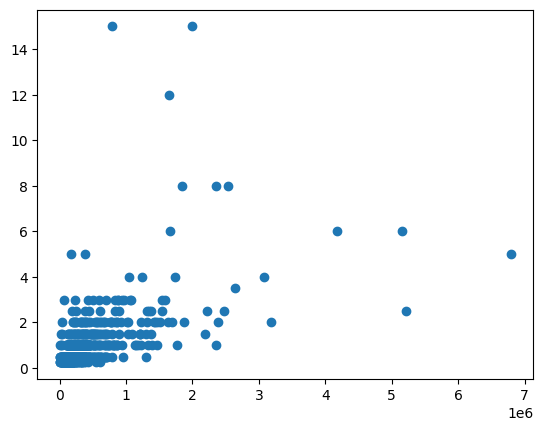

In [177]:
plt.scatter(train_df['pothole_area_mm2'], train_df['bags_used_rounded'])

In [178]:
train_df['bags_used_rounded'].value_counts().sort_index()

bags_used_rounded
0.25     168
0.50     366
1.00     183
1.50      63
2.00      48
2.50      14
3.00      15
3.50       1
4.00       4
5.00       3
6.00       3
8.00       3
12.00      1
15.00      2
Name: count, dtype: int64

### Outlier Removal

In [49]:
features = train_df[['pothole_area_mm2', 'pothole_length', 'pothole_width', 'mm_to_pixel_ratio', 'bags_used']]

KeyError: "['pothole_length', 'pothole_width'] not in index"

In [50]:
iso_forest = IsolationForest(contamination=0.1, random_state=42)

In [51]:
outliers = iso_forest.fit_predict(features)

NameError: name 'features' is not defined

In [52]:
train_df_no_outliers = train_df[outliers == 1]

ValueError: Item wrong length 874 instead of 871.

In [53]:
print("Original DataFrame shape:", train_df.shape)
print("DataFrame after removing outliers shape:", train_df_no_outliers.shape)

Original DataFrame shape: (871, 5)


NameError: name 'train_df_no_outliers' is not defined

In [54]:
plt.scatter(train_df_no_outliers['pothole_area_mm2'], train_df_no_outliers['bags_used'])

NameError: name 'train_df_no_outliers' is not defined

In [55]:
train_df_no_outliers['bags_used_rounded'].value_counts().sort_index()

NameError: name 'train_df_no_outliers' is not defined

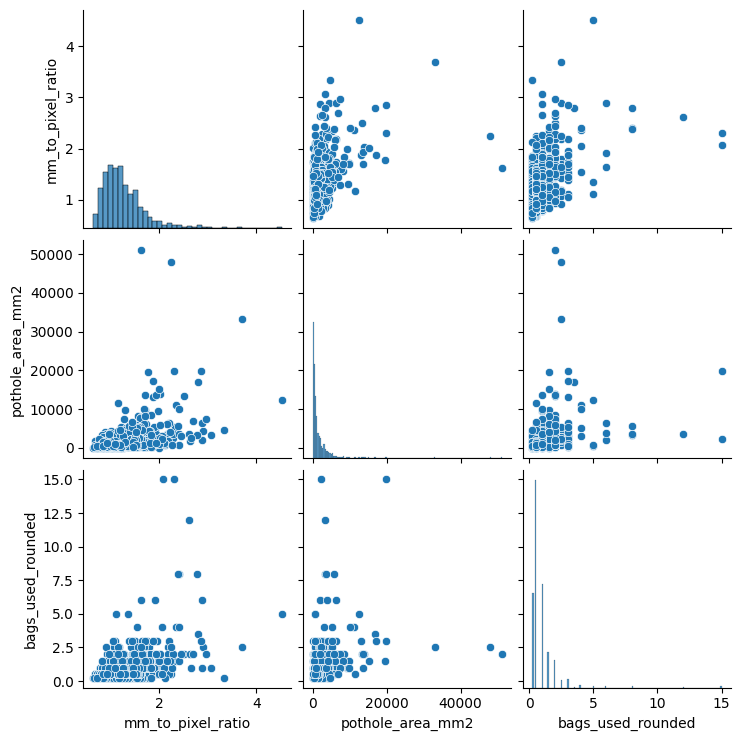

In [56]:
#sns.pairplot(train_df_no_outliers.drop('bags_used', axis=1))
sns.pairplot(train_df.drop('bags_used', axis=1))

In [57]:
train_df_no_outliers.drop('bags_used', axis=1, inplace=True)

NameError: name 'train_df_no_outliers' is not defined

In [58]:
train_df_no_outliers.head(10)

NameError: name 'train_df_no_outliers' is not defined

# Splitting the data

In [179]:
#X = train_df_no_outliers.drop(['bags_used_rounded', 'pothole_id'], axis=1)
#y = train_df_no_outliers['bags_used_rounded']

X = train_df.drop(['bags_used_rounded','bags_used', 'pothole_id'], axis=1)
y = train_df['bags_used']

In [180]:
X.head(3)

,mm_to_pixel_ratio,pothole_length_mm,pothole_width_mm,pothole_area_mm2,pothole_aspect_ratio,pothole_perimeter_mm,pothole_compactness
0,2.024225,485.814034,368.408976,1.143629e+05,1.318681,1708.446019,0.039182
1,2.233278,1817.888392,1181.404127,1.685416e+06,1.538752,5998.585037,0.046839
2,2.744603,850.826793,606.557165,3.453620e+05,1.402715,2914.767916,0.040651


In [181]:
#features = ['pothole_area_mm2']
#X = X[features]

In [182]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.2)

# Scaling the data

In [183]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [184]:
scaler_big = StandardScaler()
X_scaled = scaler_big.fit_transform(X)

# Modelling

## KNN Regression

In [185]:
from sklearn.neighbors import KNeighborsRegressor

In [186]:
knn_model = KNeighborsRegressor(n_neighbors=20)

In [187]:
knn_model.fit(X_train_scaled, y_train)

KNeighborsRegressor(n_neighbors=20)

In [188]:
y_val_pred = knn_model.predict(X_val_scaled)

In [189]:
print(r2_score(y_val, y_val_pred))

0.5199157571071291


### Cross val

In [190]:
knn_model = KNeighborsRegressor(n_neighbors=20)
r2_scorer = make_scorer(r2_score)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [191]:
cv_r2_scores = cross_val_score(knn_model, X_scaled, y, cv=kf, scoring=r2_scorer)

In [192]:
print("R² scores for each fold:", cv_r2_scores)
print("Mean R² score:", cv_r2_scores.mean())

R² scores for each fold: [    0.51456     0.53252    0.086727     0.33068     0.14251     0.11975     0.63015     0.25085    0.017988     0.38345]
Mean R² score: 0.300919351090895


## Poisson Regression

In [193]:
poisson_model = PoissonRegressor(alpha=0.01, max_iter=10000)
poisson_model.fit(X_train_scaled, y_train)

PoissonRegressor(alpha=0.01, max_iter=10000)

In [194]:
y_val_pred = poisson_model.predict(X_val_scaled)

In [195]:
print(r2_score(y_val, y_val_pred))

0.4894212445190278


#### Param Tuning

In [196]:
poisson_regressor = PoissonRegressor(max_iter=1000)

# Define the parameter grid to search
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0],  # Regularization strength
    'fit_intercept': [True, False],
    'max_iter': [1000, 2000, 3000],  # Maximum number of iterations
    'tol': [1e-4, 1e-3, 1e-2]  # Tolerance for stopping criteria
}

In [197]:
grid_search = GridSearchCV(estimator=poisson_regressor, param_grid=param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)

In [198]:
grid_search.fit(X_scaled, y)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'alpha': 0.1, 'fit_intercept': True, 'max_iter': 1000, 'tol': 0.001}


#### Cross val

In [199]:
poisson_model = PoissonRegressor(alpha=1.0, fit_intercept=True, max_iter=1000, tol=0.001)

In [200]:
r2_scorer = make_scorer(r2_score)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [201]:
cv_r2_scores = cross_val_score(poisson_model, X_scaled, y, cv=kf, scoring=r2_scorer)

In [202]:
print("R² scores for each fold:", cv_r2_scores)
print("Mean R² score:", cv_r2_scores.mean())

R² scores for each fold: [     0.4347     0.43227     0.10479    -0.51501     0.32548]
Mean R² score: 0.15644867308454127


## Linear Regression

In [203]:
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

LinearRegression()

In [204]:
y_val_pred = linreg.predict(X_val_scaled)

In [205]:
print(r2_score(y_val, y_val_pred))

0.5103893411563396


#### Cross val

In [206]:
r2_scorer = make_scorer(r2_score)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [207]:
cv_r2_scores = cross_val_score(linreg, X_scaled, y, cv=kf, scoring=r2_scorer)

In [208]:
print("R² scores for each fold:", cv_r2_scores)
print("Mean R² score:", cv_r2_scores.mean())

R² scores for each fold: [    0.51118     0.37851     0.09434     0.34466     0.45918]
Mean R² score: 0.35757509433520945


## Ridge

In [209]:
ridge = Ridge(alpha=3.0)
ridge.fit(X_train_scaled, y_train)

Ridge(alpha=3.0)

In [210]:
y_val_pred = ridge.predict(X_val_scaled)

In [211]:
print(r2_score(y_val, y_val_pred))

0.5114085485818771


#### Cross Val

In [212]:
r2_scorer = make_scorer(r2_score)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [213]:
cv_r2_scores = cross_val_score(ridge, X_scaled, y, cv=kf, scoring=r2_scorer)

In [214]:
print("R² scores for each fold:", cv_r2_scores)
print("Mean R² score:", cv_r2_scores.mean())

R² scores for each fold: [     0.5114     0.38062     0.10069     0.34596     0.45912]
Mean R² score: 0.3595568409552004


## Non Linear Poisson Regression

## Support Vector Regression

In [ ]:
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

In [ ]:
svr_model.fit(X_train_scaled, y_train)

In [ ]:
y_pred_val = svr_model.predict(X_val_scaled)

In [ ]:
print(r2_score(y_val, y_pred_val))

#### Param Tuning

In [ ]:
svr_model = SVR()

# Define the parameter grid to search
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    #'degree': [2, 3, 4]  # Only relevant for 'poly' kernel
}

In [ ]:
grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=7, scoring='r2', verbose=1, n_jobs=-1)

In [ ]:
grid_search.fit(X_scaled, y)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

#### Cross Val

In [ ]:
svr_model = SVR(kernel='linear', C=2, epsilon=0.05)

In [ ]:
r2_scorer = make_scorer(r2_score)
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [ ]:
cv_r2_scores = cross_val_score(svr_model, X_scaled, y, cv=kf, scoring=r2_scorer)

In [ ]:
print("R² scores for each fold:", cv_r2_scores)
print("Mean R² score:", cv_r2_scores.mean())

# Prediction Model

In [164]:
model = KNeighborsRegressor(n_neighbors=30)
model.fit(X_scaled, y)

KNeighborsRegressor(n_neighbors=30)

In [165]:
test_df.head(3)

,pothole_id,mm_to_pixel_ratio,pothole_area_mm2
0,p1181,1.303747,581.316290
1,p1430,0.973253,368.459440
2,p1409,1.204819,169.756133


In [166]:
#X_test_scaled = scaler_big.transform(test_df.drop('pothole_id', axis=1)[features])
X_test_scaled = scaler_big.transform(test_df.drop('pothole_id', axis=1))

In [167]:
y_pred = model.predict(X_test_scaled)

## Prediction Dataset

In [ ]:
pred_df = pd.DataFrame({
    'Pothole number': test_df['pothole_id'],
    'Bags used ': y_pred
})

# Display the first few rows of pred_df
pred_df.head(30)

In [ ]:
pred_df['Pothole number'] = pred_df['Pothole number'].str.replace("p","").astype(int)
pred_df = pred_df.sort_values('Pothole number')

In [ ]:
pred_df.set_index('Pothole number', inplace=True)

In [ ]:
pred_df.to_csv('../../data/predictions/KNeighbours_1_added_feats.csv')

In [ ]:
pred_df.sort_index().head(30)

In [37]:
pd.read_csv('../../data/predictions/best.csv')

,Pothole number,Bags used
0,103,1.00
1,104,0.75
2,105,0.75
3,108,0.75
4,114,2.00
5,143,1.00
6,144,0.50
7,406,3.00
8,434,1.00
9,450,1.50
